# Import:
1. import os library for collecting the text files.
2. import string and nltk for tokenizing the files.
3. import re library to use regex for reading the cran files.
4. matplotlib.pyplot and sns for sketching plots for evaluation parts.

We use nltk to find the stem of each term and also find every stopword in english.

In [35]:
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Get input files:

We get the Text and Title part of each document using read_document function.

1. Open and read file.
2. split documents (by .I)
3. use extract_title_and_Text function to extract Text and Title part for each document.

In [36]:
def extract_title_and_Text(file_content):
    # Extract title (.T) and Text (.W) parts
    title_match = re.search(r'\.T\s*([\s\S]+?)(?=(\.[A-Z]|\Z))', file_content)
    Text_match = re.search(r'\.W\s*([\s\S]+?)(?=(\.[A-Z]|\Z))', file_content)

    title = title_match.group(1).strip() if title_match else ''
    Text = Text_match.group(1).strip() if Text_match else ''

    return title, Text

def read_documents():
    with open('cran.all.1400', 'r') as file:
        content = file.read()
        
    # Split the content into documents based on the ".I" delimiter
    documents = re.split(r'\.I \d+', content)[1:]

    Texts = []
    Titles = []
    for doc in documents:
        title, text = extract_title_and_Text(doc)
        # Check if it's not empty
        if title != '' and text != '':
            Texts.append(text)
            Titles.append(title)

    return Texts, Titles

We get the queries using read_queries function.

1. Open and read file.
2. split queries (by .I)
3. use extract_queries function to extract Text for each query.

In [37]:
def extract_query(file_content):
    # Extract title (.T) part
    Text_match = re.search(r'\.W\s*([\s\S]+?)(?=(\.[A-Z]|\Z))', file_content)
    Text = Text_match.group(1).strip() if Text_match else ''

    return Text

def read_queries():
    with open('cran.qry', 'r') as file:
        content = file.read()
        
    # Split the content into documents based on the ".I" delimiter
    documents = re.split(r'\.I \d+', content)[1:]

    queries = []
    for doc in documents:
        # Check if it's not empty
        text = extract_query(doc)
        if text != '':
            queries.append(text)

    return queries

Building a dictionary which shows the relevance of each query to some documents (others have zero relevancy)

1. Open and read file.
2. split the data.
3. create a dictionary that shows how are some documents relevant to queries (1 throught 225).

In [38]:
def read_rel():
    with open('cranqrel', 'r') as file:
        content = file.read()
    
    # Split and convert the data to integer
    data = [eval(num) for num in content.split()]
    # The dictionary to store query, document and it's relevancy
    que_doc_rel = dict({})
    
    for i in range(0, len(data), 3):
        if data[i+2] > 0:
            if data[i] in que_doc_rel:
                que_doc_rel[data[i]][data[i+1]] = data[i+2]
            else:
                que_doc_rel[data[i]] = {data[i+1]:data[i+2]}
            
    return que_doc_rel

# Tokenize:

In this cell, every text files, convert to a list whitout any puntuation and stop word.

1. Punctuation are not important at all, so removing them helps the document retreival.
2. Removing stop words is important beacuse they don't add much value to a text and make our search more sufficient and faster.
3. Also we convert every character to it's lower case. And we do the same with query So that makes search and comparing more easy.
4. And store each term stem instead of the term itself.

Also we get terms of each document as a set and get union with other document terms. So we will have all unique terms in the document collection.

In [39]:
def tokenize(documents):
    # Set the stop words for English
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    # This is the final list of tokenized text in lists
    tokenized_list = []
    terms = set([])
    
    # For each document, we use nltk regex_tokenize to token all the text file
    for doc in documents:
        tokenized_text =  nltk.regexp_tokenize(doc, r'\d+,\d+|\w+')
        
        # Here we handle ',' in the numbers (beacuse nltk doesn't handle this)
        for i in range(len(tokenized_text)):
            if ',' in tokenized_text[i]:
                w = ''
                for c in tokenized_text[i]:
                    if c != ',':
                        w += c 
                    tokenized_text[i] = w
        
        # Then remove any punctuation and store the stem of each term
        text_without_punctuation = [porter.stem(word) for word in tokenized_text if word.isalnum()]
        
        # And remove the stop words cause they don't add much to a text
        text_without_stop_words = [word for word in text_without_punctuation if word not in stop_words]
        
        tokenized_list.append(text_without_stop_words)
        
        # Getting unique terms till now
        terms = terms.union(set(text_without_stop_words))
    
    return tokenized_list, list(terms)

# Inverted Index:

Construct inverted index, a dictionary for document and collection frequency of each term using this function.

for each term in each document:
1. First check if it is already in the dictionary.
2. If not, add it to the dictionary with the value of dictionary storing it's document and it's frequency in it.
3. If is, Check if the document is new to the dictionary value of the term.
4. If is add a document to it's documents.
5. If not, increament the term frequency of that document.

Meanwhile, Update the collection frequecy (cf) and document frequency (df) for each term.
1. df will be increamented if it is a new document.
2. cf will be increased each time the term is seen.

In [40]:
def inverted_index(n_documents, tokenized_list):
    # This is the dictionary for inverted index that we will construct
    inv_ind = dict()
    # Dictionaries to store document and collection frequency of each term.
    df = dict()
    cf = dict()
    
    for doc_id in range(n_documents):
        for token_index in range(len(tokenized_list[doc_id])):
            token = tokenized_list[doc_id][token_index]
            # Checking if the term is already in the dictionary
            if token in inv_ind:
                # If the document has already been added to the term's documents
                if doc_id in list(inv_ind[token].keys()):
                    inv_ind[token][doc_id] += 1
                    cf[token] += 1
                # If this is a new document
                else:
                    inv_ind[token][doc_id] = 1
                    df[token] += 1
                    cf[token] += 1
            # If this is a new term
            else:
                inv_ind[token] = {doc_id:1}
                df[token] = 1
                cf[token] = 1
                
    return inv_ind, df, cf

# Construct tf_idf:

We will construct tf-idf matrix, by calculating the tf and idf:

1. for each term, for each document that has the term inside:
2. get the tf (stored in the inside dictionary with key the document).
3. get the idf using the formula: $$idf = \log(\frac{N}{df})$$ where df is stored in df dictionary for the term.
4. At last, divide the column vector (each document embeding) by it's norm to normalize the matrix.

$\bullet$ $tf\_idf_{t,d} = tf_{t, d}\cdot\log(\frac{N}{df_{t}})$ 

In [41]:
def construct_tf_idf_mat(inverted_index, df, terms, n_documents, n_terms):
    # The tf_idf matrix
    tf_idf = np.zeros((n_terms, n_documents), dtype='float')
    
    for i in range(n_terms):
        for j in list(inverted_index[terms[i]].keys()):
            tf = inverted_index[terms[i]][j]
            idf = np.log2(n_documents/df[terms[i]])
            tf_idf[i][j] = tf*idf
            
    for j in range(n_documents):
        # Calculating the norm of column vector
        s = 0
        for i in range(n_terms):
            s += tf_idf[i][j]**2
        s = s**(1/2)
        # Normalizing the column
        for i in range(n_terms):
            tf_idf[i][j] = tf_idf[i][j]/s
            
    return tf_idf

# Query to vector:

This function is used to get a query and convert it to a vector.

1. Get the query and tokenize it using tokenize function.
2. Then for each term in the query, add one to it's vector element related to that term in terms list.
3. At last normalize the vector by dividing it by it's norm.

In [42]:
def query_to_vector(query, terms, n_terms):
    # Tokenize it
    token_query, _ = tokenize([query])
    token_query = token_query[0]
    query_vector = np.zeros(n_terms, dtype='float')
    # Build the base embeding
    for token in token_query:
        if token in terms:
            index = terms.index(token)
            query_vector[index] += 1
    
    # Normalize the vector
    norm = np.linalg.norm(query_vector)
    query_vector = query_vector/norm
    return query_vector

# Cosine similarity:

This function is used to find the similarity between a query and a document.

1. for each document.
2. calculate the inner product of it's embeding by the query embeding.
3. divide it by the length of the document.
4. Update the scores for the document.
$$ score(q, d) = \overrightarrow{v(q)}\cdot\overrightarrow{v(d)} $$

$\bullet$ Doing the last part is important. Because a term is more likely to be appeared in a long document than a short one. So considering the length of the document, determines the importance of each term that is also in the query, in the document.

In [43]:
def cosine_score(query_vec, tf_idf, n_terms, n_documents, len_documents):
    scores = np.zeros(n_documents, dtype='float')
    
    for doc_id in range(n_documents):
        # Calculate inner product
        for term in range(n_terms):
            if tf_idf[term][doc_id] > 0:
                scores[doc_id] += query_vec[term]*tf_idf[term][doc_id]
                
        # Normalize by the length of document
        scores[doc_id] = scores[doc_id]/len_documents[doc_id]
        
    return scores

# Space vector model:

This is the space vector model:
1. First we get the vector for query.
2. get the k_best.
3. use cosine_score function to calculate the similarity of the query with each document.
4. then return the k_best by finding the max each time and change it to $-\infty$.

In [44]:
def space_vector(tf_idf, terms, n_terms, n_documents, len_documents, queries, query_id, k_best):
    # Get the query
    query = queries[query_id-1]
    query_vector = query_to_vector(query, terms, n_terms)
    # Calculate scores
    scores = cosine_score(query_vector, tf_idf, n_terms, n_documents, len_documents)
    
    # find k_best
    doc_score = []
    for k in range(n_documents):
        k_max = max(scores)
        index = np.where(scores == k_max)[0][0] + 1
        # change it to -infinity
        scores[index-1] = -np.inf
        # Handling two empty documents
        if index >= 471:
            index += 1
            if index >= 995:
                index += 1
        doc_score.append({"Id":index, "Score":k_max})

    return doc_score, doc_score[:k_best]

# RSV score:

Using this function with parameter k1, k3 and b, we can find the similarity between the given query and all documents in the collection.

1. For each document:
2. For each term in the query:
3. Get the term frequency (tf) from inverted index and do the smoothing by 0.05.
4. Find the idf: $$idf = \log(\frac{N}{df})$$
5. Find the document case: $$\frac{(k_1+1)tf_{td}}{k_1((1-b) +b(L_d/L_{ave})) + tf_{td}} $$ where $L_{ave}$ is the average length of documents in the collection.
6. Find the query case: $$ \frac{(k_3+1)tf_{tq}}{k_3 + tf_{tq}} $$
7. Now calculate $RSV_td$ by multiplying 4, 5 and 6: $$ RSV_{td} = \log(\frac{N}{df})\cdot \frac{(k_1+1)tf_{td}}{k_1((1-b) +b(L_d/L_{ave})) + tf_{td}} \cdot \frac{(k_3+1)tf_{tq}}{k_3 + tf_{tq}} $$
8. So, the RSV for a document based on the given query is: $$ RSV_d = \Sigma_{t \in q}{} \log(\frac{N}{df})\cdot \frac{(k_1+1)tf_{td}}{k_1((1-b) +b(L_d/L_{ave})) + tf_{td}} \cdot \frac{(k_3+1)tf_{tq}}{k_3 + tf_{tq}} $$

$\bullet$ If the query length is less than 20, $k_3$ is considered zero so that the third division is equal to 1 (not long query).

In [45]:
def RSV(k1, k3, b, inv_ind, df, len_documents, n_documents, n_terms, token_query):
    rsv = np.zeros(n_documents, dtype='float')
    # Average length
    l_ave = np.mean(len_documents)
    
    # If it's not long query
    if len(token_query) < 20:
        k3 = 0
    
    for doc_id in range(n_documents):
        for term in token_query:
            # tf with smoothing
            if doc_id in list(inv_ind[term].keys()):
                tf = inv_ind[term][doc_id] 
            else:
                tf = 0
            tf += 0.05
            
            # calculate RSV
            idf = np.log2(n_documents/df[term])
            doc_case = ((k1 + 1)*(tf))/(k1*((1-b) + b*(len_documents[doc_id]/l_ave)) + tf)
            que_case = ((k3+1)*tf)/(k3+tf)
            rsv[doc_id] += idf*doc_case*que_case
    
    return rsv

# Probabilistic model:
This is the Probebilistic model:
1. First we get the vector for query.
2. get the k_best.
3. use RSV function to calculate the similarity of the query with each document.
4. then return the k_best by finding the max each time and change it to $-\infty$.

In [46]:
def Probabilistic_model(k1, k3, b, inv_ind, df, len_documents, n_documents, n_terms, queries, query_id, k_best):
    # query
    query = queries[query_id-1]
    token_query, _ = tokenize([query])
    token_query = token_query[0]
    # Give score
    scores = RSV(k1, k3, b, inv_ind, df, len_documents, n_documents, n_terms, token_query)
    
    # find k_best
    doc_score = []
    for k in range(n_documents):
        k_max = max(scores)
        index = np.where(scores == k_max)[0][0] + 1
        # change it to -infinity
        scores[index-1] = -np.inf
        # Handling two empty documents
        if index >= 471:
            index += 1
            if index >= 995:
                index += 1
        doc_score.append({"Id":index, "Score":k_max})

    return doc_score, doc_score[:k_best]

# Query Likelihood:
Using this function with parameter $\lambda$, a similarity score is calculated.

1. For each document:
2. For each term in the query:
3. Get the term frequency (tf) from inverted index.
4. Calculate prob_t_Md: $$ \hat{P}(t|M_d) = \frac{tf_{t,d}}{L_d} $$ where $L_d$ equals to length of the document.
5. Calculate prob_t_Mc: $$ \hat{P}(t|M_c) = \frac{cf_t}{T} $$ where $T = \Sigma_{t}cf_t$.
6. Calculate prob_t_d: $$ P(t|d) = \lambda P(t|M_d) + (1-\lambda)P(t|M_c) $$
7. So for each document, for the probability will have: $$ P(q|d) \propto P(d) \prod_{1 \leq k \leq |q|} (\lambda P(t_k|M_d) + (1-\lambda)P(t_k|M_c)) $$

$\bullet$ We use $\log$ case of the probability and consider the proiors uniform: $$ \log(P(q|d)) \propto \Sigma_{1 \leq k \leq |q|} \log(\lambda P(t_k|M_d) + (1-\lambda)P(t_k|M_c)) $$


In [47]:
def prob_query_document(lam, inv_ind, cf, len_documents, n_documents, n_terms, collection_size, token_query):
    prob = np.zeros(n_documents, dtype='float')
    
    for doc_id in range(n_documents):
        for term in token_query:
            # Get tf
            if doc_id in list(inv_ind[term].keys()):
                tf = inv_ind[term][doc_id] 
            else:
                tf = 0
            
            # Calculate probability
            prob_t_Md = tf/len_documents[doc_id]
            prob_t_Mc = cf[term]/collection_size
            prob_t_d = lam*prob_t_Md + (1-lam)*prob_t_Mc
            prob[doc_id] += np.log2(prob_t_d)
            
    return prob

# Language model:

This is the Language model:
1. First we get the vector for query.
2. get the k_best.
3. use prob_query_document function to calculate the probability that the query is from a document.
4. then return the k_best by finding the max each time and change it to $-\infty$.

In [48]:
def language_model(lam, inv_ind, cf, len_documents, n_documents, n_terms, collection_size, queries, query_id, k_best):
    # query
    query = queries[query_id-1]
    token_query, _ = tokenize([query])
    token_query = token_query[0]
    # Give score
    scores = prob_query_document(lam, inv_ind, cf, len_documents, n_documents, n_terms, collection_size, token_query)
    
    # find k_best
    doc_score = []
    for k in range(n_documents):
        k_max = max(scores)
        index = np.where(scores == k_max)[0][0] + 1
        # change it to -infinity
        scores[index-1] = -np.inf
        # Handling two empty documents
        if index >= 471:
            index += 1
            if index >= 995:
                index += 1
        doc_score.append({"Id":index, "Score":k_max})

    return doc_score, doc_score[:k_best]

# 11-point interpolated average precision:

This function is using related queries and document ranks to find out the precisions when recall is 0, 0.1, 0.2, ..., 0.9, 1.

1. Iterate over the scores.
2. If the document is relevant, increase the relevant counter.
3. If the recall is nearest larger recall to 0, 0.1, 0.2, ..., 0.9, 1, store the precision.
4. Return eleven stored precisions.

In [49]:
def elev_point_interpolated_ave_per(que_doc_rel, query_id, scores, n_documents):
    # recalls that the precisions should be stored in
    recall_point_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    precision = [1.0]
    
    relevant = 0
    rel_doc = list(que_doc_rel[query_id].keys())
    total_rel = len(rel_doc)
    
    j = 0
    for i in range(n_documents):
        # If it is a relevant document, increase the relevant counter
        if scores[i]["Id"] in rel_doc:
            relevant += 1
            
        # Calculate recall and precision
        r = relevant/total_rel
        p = relevant/(i+1)
        
        # Store the precision if it is the first larger near to recall points
        while r >= recall_point_list[j]:
            precision.append(p)
            j += 1
            if j == 10:
                break
        
        # All relevant documents have been retreived
        if r == 1:
            break
    
    return precision

# Plot:

We sketch the recall-precision plot.

In [50]:
def sketch_plot(precision_spa_vec, precision_prob, precision_lang, title):    
    recall = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    # Set style
    sns.set(style='darkgrid', rc={'axes.labelsize': 8, 'axes.titlesize': 10, 'legend.fontsize': 8})
    # Create a 2x4 grid of subplots

    plt.figure(figsize=(12, 5))
    # plot the data
    sns.lineplot(x=recall, y=precision_spa_vec, label='Space vector', color='blue')
    sns.lineplot(x=recall, y=precision_prob, label= 'Probabilistic', color='orange')
    sns.lineplot(x=recall, y=precision_lang, label='language', color='green') 
    plt.title(title, fontsize=10)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.xticks(np.arange(0, 1.0000001, 0.1))

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# information retreival:

This function is used to retreive documents based on differente IR systems for a given query. Then use the 11-interpolation to get 11 precision for each system.

1. Space vector model: for this model, we use the related fuction to get the ranking scores.
2. probabilistic model: for this model, we use the related fuction with parameters $k_1 = 1.2$, $k_3 = 2$ and $b = 0.75$ as these are reasonable values based on different experiments. $k_1$ is determining that how much a term in the document is important. $k_3$ is showing how much a term is important in a given query. And finally, $b$ is determining that how much we should consider the importance of document length.
3. language model: for this model, we use the related function with parameter $\lambda = 0.9$ as this is a reasonable value for smoothing (smoothing with $0.1$ importance). If $\lambda$ was larger, then the smoothing and collection importance would be less important. And if it was smaller, the document importance would be less.

In [51]:
def query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, query_id, k_best):
    # IR based on space vector model
    scores_sv, k_best_sv = space_vector(tf_idf, terms, n_terms, n_documents, len_documents, queries, query_id, k_best)
    precision_sv = elev_point_interpolated_ave_per(que_doc_rel, query_id, scores_sv, n_documents)
    
    # IR based on probabilistic model
    scores_prob, k_best_prob = Probabilistic_model(1.2, 2, 0.75, inv_ind, df, len_documents, n_documents, n_terms, queries, query_id, k_best)
    precision_prob = elev_point_interpolated_ave_per(que_doc_rel, query_id, scores_prob, n_documents)
    
    # IR based on language model
    scores_lm, k_best_lm = language_model(0.9, inv_ind, cf, len_documents, n_documents, n_terms, collection_size, queries, query_id, k_best)
    precision_lm = elev_point_interpolated_ave_per(que_doc_rel, query_id, scores_lm, n_documents)
    
    return precision_sv, precision_prob, precision_lm, k_best_sv, k_best_prob, k_best_lm

# Construct everything needed:

1. First of all, Get the data from related files.
2. Tokenize the documents and Find unique terms.
3. Find the size of anything we use for easier work later.
4. Construct inverted index, document frequency (df) and collenction frequency (cf) dictionaries.
5. Construct the tf-idf matrix to use in space vector model.

$\bullet$ Test queries are such that the number of related documents is multiple of 10 so that we can use 11-point interpolated on them.

In [52]:
# Get input
Texts, Titles = read_documents()
queries = read_queries()
que_doc_rel = read_rel()
# such that the number of related documents is multiple of 10 for using 11-point interpolate
test_queries = [38, 51, 53, 55, 56, 73, 97, 147]
# tokenize
tokenized_list, terms = tokenize(Texts)
# Calculate sizes that we need
collection_size = sum([len(x) for x in tokenized_list])
len_documents = [len(tok_lis) for tok_lis in tokenized_list]
n_documents = len(Titles)
n_terms = len(terms)
# inverted index, df and cf
inv_ind, df, cf = inverted_index(n_documents, tokenized_list)
# tf-idf matrix
tf_idf = construct_tf_idf_mat(inv_ind, df, terms, n_documents, n_terms)

This cell is used to sketch the average precision/recall for every query (225 query in cranqrel file).

It can be seen that first we use the query_IR function for every query, calculate the precisions and at last, calculate the average precision. Then sketch the plot using the related function.

As we can see, in average the IR systems are doing their job better in the following order:
1. Probabilistic model
2. language model
3. space vector model

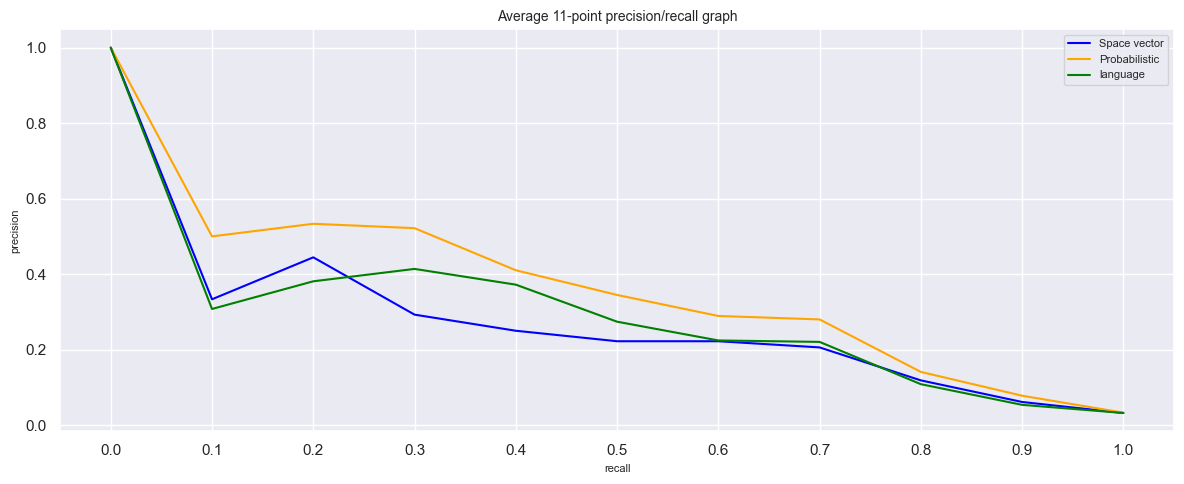

In [53]:
p_sv = np.zeros(11, dtype='float')
p_prob = np.zeros(11, dtype='float')
p_lm = np.zeros(11, dtype='float')

for query_id in range(1, 226):
    pre_sv, pre_prob, pre_lm, _, _, _ = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 157, 10)
    p_sv += np.array(pre_sv)
    p_prob += np.array(pre_prob)
    p_lm += np.array(pre_lm)

p_sv, p_prob, p_lm = p_sv/225, p_prob/225, p_lm/225

sketch_plot(p_sv, p_prob, p_lm, "Average 11-point precision/recall graph")

This is the precision/recall for $1^{st}$ query in the file.

1. Probabilistic model
2. space vector model
3. language model

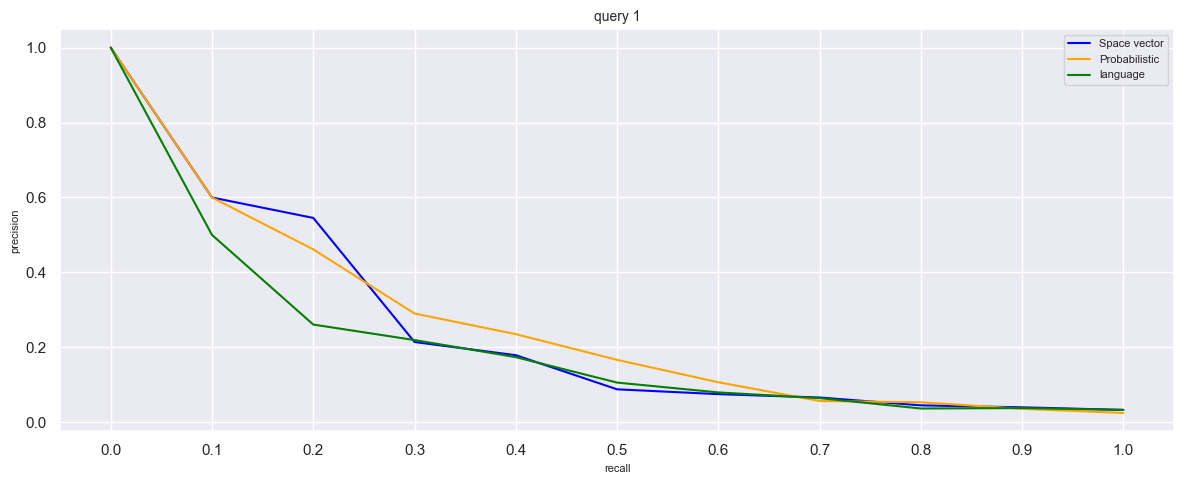

In [54]:
pre_sv, pre_prob, pre_lm, k_sv, k_prob, k_lm = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 1, 10)
sketch_plot(pre_sv, pre_prob, pre_lm, "query 1")

This is the precision/recall for $2^{nd}$ query in the file.

1. Probabilistic
2. language model
3. space vector model

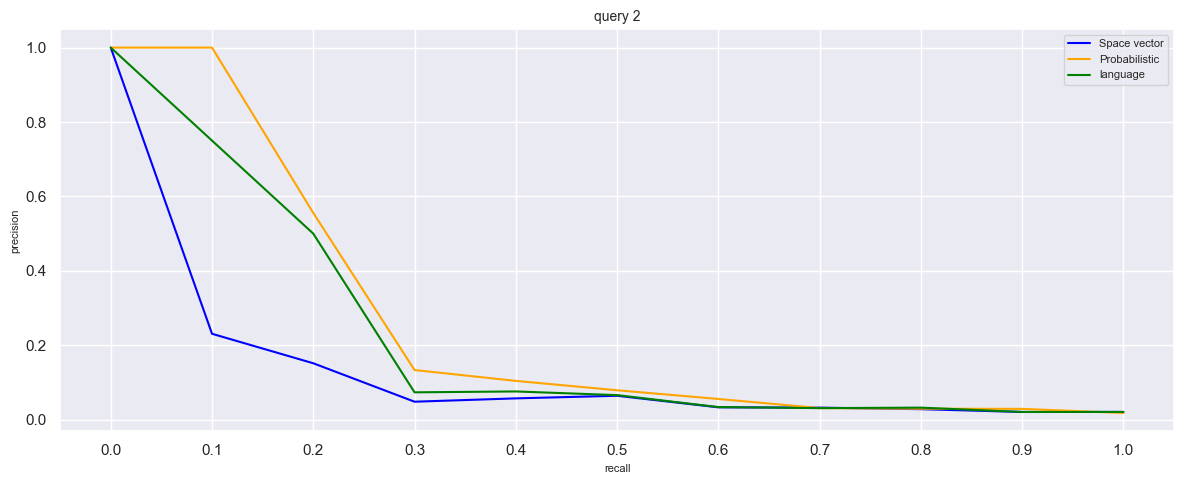

In [55]:
pre_sv, pre_prob, pre_lm, k_sv, k_prob, k_lm = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 2, 10)
sketch_plot(pre_sv, pre_prob, pre_lm, "query 2")

This is the precision/recall for $23^{th}$ query in the file.

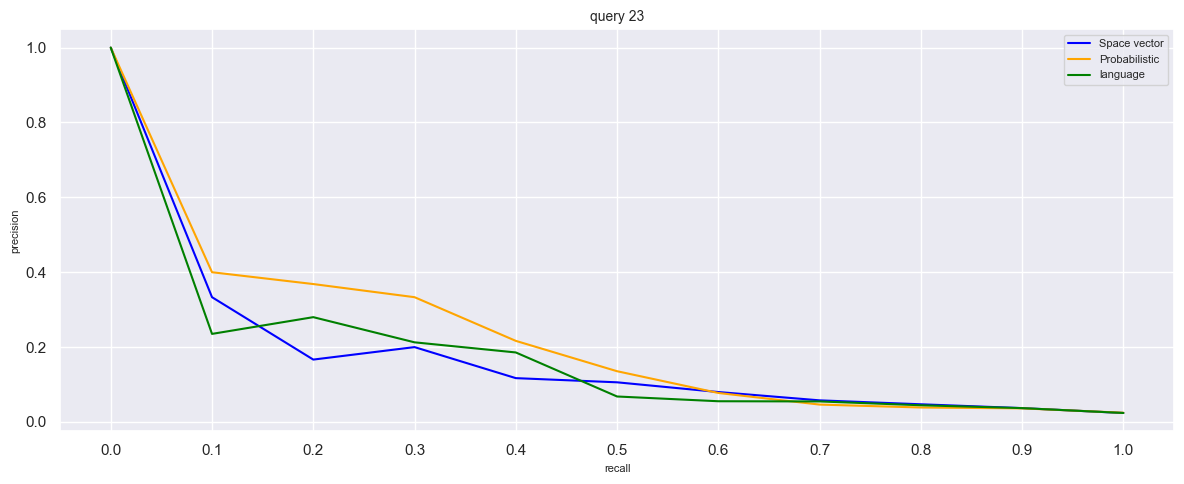

In [56]:
pre_sv, pre_prob, pre_lm, k_sv, k_prob, k_lm = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 23, 10)
sketch_plot(pre_sv, pre_prob, pre_lm, "query 23")

This is the precision/recall for $73^{th}$ query in the file.

1. language model
2. probabilistic
3. space vector model

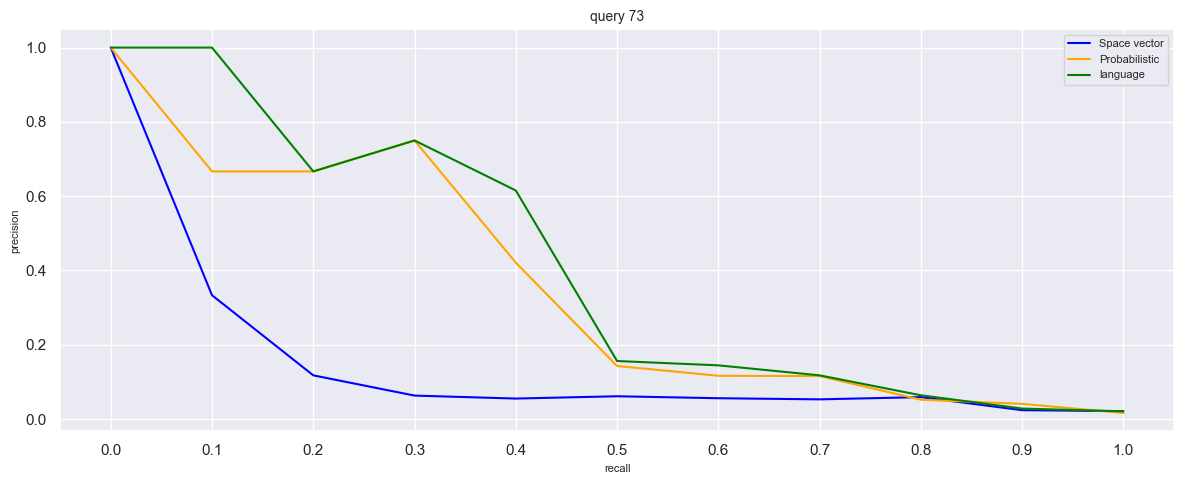

In [57]:
pre_sv, pre_prob, pre_lm, k_sv, k_prob, k_lm = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 73, 10)
sketch_plot(pre_sv, pre_prob, pre_lm, "query 73")

This is the precision/recall for $157^{th}$ query in the file.

1. Probabilistic
2. language model
3. space vector model

this plot is as same as the average plot.

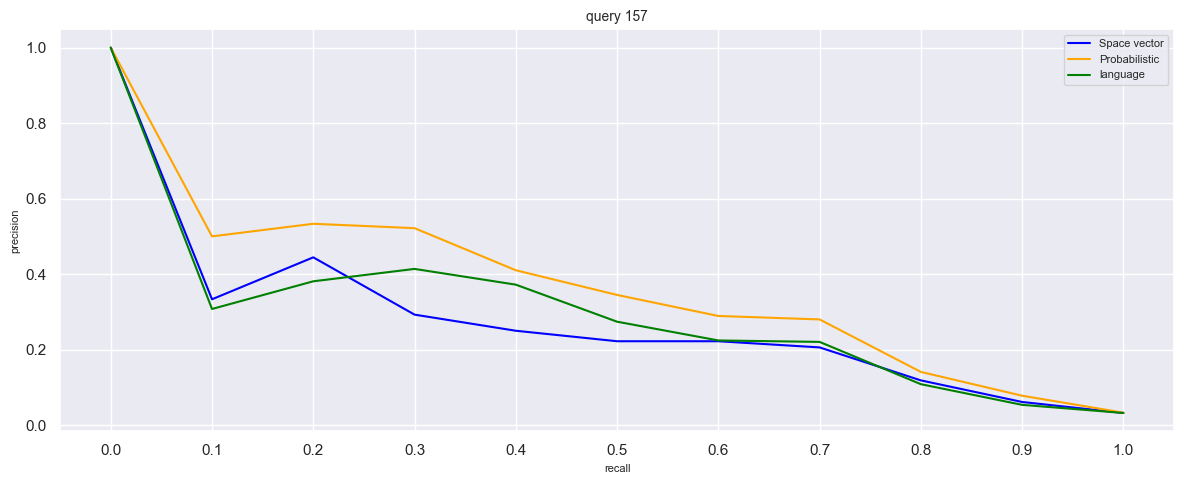

In [58]:
pre_sv, pre_prob, pre_lm, k_sv, k_prob, k_lm = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 157, 10)
sketch_plot(pre_sv, pre_prob, pre_lm, "query 157")

So you can get the precisions and k_best documents using the query_IR function for each IR system.

This is an example for first query in dataset:

In [59]:
pre_sv, pre_prob, pre_lm, k_sv, k_prob, k_lm = query_IR(tf_idf, terms, n_terms, n_documents, len_documents, inv_ind, df, cf, collection_size, queries, 1, 10)

10 best documents related to first query in space vector model.

In [60]:
print(k_sv)

[{'Id': 879, 'Score': 0.007558519895760402}, {'Id': 429, 'Score': 0.005520719954850928}, {'Id': 878, 'Score': 0.0038063165411451744}, {'Id': 875, 'Score': 0.00357041019303648}, {'Id': 12, 'Score': 0.0035235875111148756}, {'Id': 102, 'Score': 0.0035192747233159173}, {'Id': 359, 'Score': 0.0034627574485829853}, {'Id': 5, 'Score': 0.0033025252061067304}, {'Id': 51, 'Score': 0.0032405879663580596}, {'Id': 670, 'Score': 0.0031895997106535664}]


10 best documents related to first query in probabilistic model.

In [61]:
print(k_prob)

[{'Id': 51, 'Score': 33.735565054984725}, {'Id': 486, 'Score': 31.15941944540978}, {'Id': 12, 'Score': 29.925871034314223}, {'Id': 878, 'Score': 28.074773014836868}, {'Id': 184, 'Score': 27.864497281075682}, {'Id': 573, 'Score': 26.64870745486609}, {'Id': 665, 'Score': 23.881511028736806}, {'Id': 879, 'Score': 22.98846435651743}, {'Id': 141, 'Score': 22.310469597772315}, {'Id': 944, 'Score': 21.90389057510787}]


10 best documents related to first query in language model.

In [62]:
print(k_lm)

[{'Id': 486, 'Score': -104.09028411253603}, {'Id': 51, 'Score': -104.55784837260418}, {'Id': 573, 'Score': -111.01042191112435}, {'Id': 12, 'Score': -111.35480115462668}, {'Id': 878, 'Score': -111.54695452632797}, {'Id': 184, 'Score': -116.64676336460894}, {'Id': 329, 'Score': -117.05582079550955}, {'Id': 665, 'Score': -118.71576652369531}, {'Id': 141, 'Score': -120.20977838762089}, {'Id': 576, 'Score': -120.91419931723027}]
